# Similarity between categorical data records

We are interested in the problem of detecting similar records within categorical data.  These may be records which differ slightly due to data misentry, missing data fields, slight variations in reporting or coding or a variety of other factors.  Alternatively they may just be natural groupings of records within a particular data set. 

We will look at this problem from the perspective of inducing a similarity or distance function over the set of all records and then clustering the results into piles of near duplicate candidates for a human to either explore or to follow up and triage.  

There are a variety of interesting ways to measure similarity between categorical records.  Many of them involve building a complex function testing matches and non-matches between rows.  Unfortunately, these approaches don't easily scale to very large amounts of data since they typically require $O(n^2)$ similarity comparisons.  For the purposes of this notebook we will make use of some recent advances in nearest neighbour search in order to reduce that complexity.  That may initially force us to restrict ourselves to simpler models.  In the case that these aren't sufficient one take an iterative approach where a coarse similarity measure was used to estimate which record pairs were likely near duplicates and a refined (and more expensive) similarity measure was applied to only those candidate records.

# Representation
In order to make use of modern techniques we need to convert our data from columns of categorical values into numerical vectors.  There are a variety of ways to do this but by far the most common would be to use a **one hot encoding**.  That is to build a new column for each categorical variable name and value and then place a one in that new column if that particular value was present within a particular row.  

Two of the most common are pandas [get_dummies](https://pandas.pydata.org/pandas-docs/version/0.23.3/generated/pandas.get_dummies.html) function or scikit-learns [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).  Both are fine functions, but for large amounts of data (particulary if some of your columns have many values) you really want to ensure that you keep good track of your column names and maintain a sparse matrix representation.  A sparse matrix representation is one where you never actually write down any of the zero values.  This is important in a one-hot encoded representation because you have one column for every single categorical value in your data set.  If, for example, one of your columns contained a name or phone number then you could easily have added hundreds of thousands of (mostly zero) columns to every row within your data matrix.  For even medium sized data sets this can quickly exceed your computers memory limit.  

For the purposes of this tutorial I'll make use of our Vectorizers library for performing this task.

# Import Some libraries

We'll need CategoricalColumnTransformer and NgramVectorizer from our vectorizers library along with a few helper functions for dealing with our data and plotting it.

In [1]:
from vectorizers import NgramVectorizer
from vectorizers.transformers import CategoricalColumnTransformer, InformationWeightTransformer
from sklearn.decomposition import TruncatedSVD
from random import sample

import pandas as pd
import numpy as np
import umap
import umap.plot

We'll add some bokeh imports for easy interactive plots

In [2]:
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

# Let's fetch some data

Health Canada has made some of it's reporting available to the public so this is a nice, real world, data set that we can use for examining potential near duplicate entries amongst categorical records.  The data set is [Canada Vigilance Adverse Reaction Online Database - Data Structure](https://www.canada.ca/en/health-canada/services/drugs-health-products/medeffect-canada/adverse-reaction-database/canada-vigilance-adverse-reaction-online-database-data-structures.html#a1).  When there are adverse reactions to drugs within Canada hospitals and manufacturers must report these problems to Health Canada.  We'll make use of this data to see if we can find interesting structure contained within categorical record data.

For ease of reproducibility, we'll download and extract the files directly in this notebook.

In [3]:
import requests
import zipfile
import os

Download the file only if it isn't already on our computer.

In [4]:
if not os.path.isfile('extract_extrait.zip'):
    print("Failed to find the data file, downloading... ")
    results = requests.get('https://www.canada.ca/content/dam/hc-sc/migration/hc-sc/dhp-mps/alt_formats/zip/medeff/databasdon/extract_extrait.zip')
    with open("extract_extrait.zip", "wb") as code:
        code.write(results.content)

In [5]:
zipped = zipfile.ZipFile('extract_extrait.zip')
zipped.namelist()

['cvponline_extract_20210331/drug_product_ingredients.txt',
 'cvponline_extract_20210331/drug_products.txt',
 'cvponline_extract_20210331/gender_lx.txt',
 'cvponline_extract_20210331/literature_reference.txt',
 'cvponline_extract_20210331/outcome_lx.txt',
 'cvponline_extract_20210331/reactions.txt',
 'cvponline_extract_20210331/report_drug_indication.txt',
 'cvponline_extract_20210331/report_drug.txt',
 'cvponline_extract_20210331/report_links.txt',
 'cvponline_extract_20210331/reports.txt',
 'cvponline_extract_20210331/report_type_lx.txt',
 'cvponline_extract_20210331/seriousness_lx.txt',
 'cvponline_extract_20210331/source_lx.txt']

Extract he file if it isn't already uncompressed.

In [6]:
if not os.path.isfile('cvponline_extract_20210331/reactions.txt'):
    print("Failed to find the uncompressed input file, extracting... ")
    zipped.extractall()

Now let's load up one of the more useful text files into a pandas data frame for manipulation.

It should be noted that these are, unfortunatly, only text dumps of the contents of a database and as such don't contain any reference to their column names.  To get those column names we're forced to go to the web linked above and cut and paste these column names directly into our code.  

In [7]:
input_file = 'cvponline_extract_20210331/reports.txt'
data = pd.read_csv(input_file, sep='$', header=None, low_memory=False)
column_names = 'REPORT_ID,REPORT_NO,VERSION_NO,DATRECEIVED,DATINTRECEIVED,MAH_NO,REPORT_TYPE_CODE,REPORT_TYPE_ENG,REPORT_TYPE_FR,GENDER_CODE,GENDER_ENG,GENDER_FR,AGE,AGE_Y,AGE_UNIT_ENG,AGE_UNIT_FR,OUTCOME_CODE,OUTCOME_ENG,OUTCOME_FR,WEIGHT,WEIGHT_UNIT_ENG,WEIGHT_UNIT_FR,HEIGHT,HEIGHT_UNIT_ENG,HEIGHT_UNIT_FR,SERIOUSNESS_CODE,SERIOUSNESS_ENG,SERIOUSNESS_FR,DEATH,DISABILITY,CONGENITAL_ANOMALY,LIFE_THREATENING,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,REPORTER_TYPE_FR,SOURCE_CODE,SOURCE_ENG,SOURCE_FR,E2B_IMP_SAFETYREPORT_ID,AUTHORITY_NUMB,COMPANY_NUMB'.split(",")
data.columns = column_names
data.shape

(874172, 42)

In [8]:
data.head(3)

,REPORT_ID,REPORT_NO,VERSION_NO,DATRECEIVED,DATINTRECEIVED,MAH_NO,REPORT_TYPE_CODE,REPORT_TYPE_ENG,REPORT_TYPE_FR,GENDER_CODE,...,HOSP_REQUIRED,OTHER_MEDICALLY_IMP_COND,REPORTER_TYPE_ENG,REPORTER_TYPE_FR,SOURCE_CODE,SOURCE_ENG,SOURCE_FR,E2B_IMP_SAFETYREPORT_ID,AUTHORITY_NUMB,COMPANY_NUMB
0,1,000000001,0,05-JUN-73,05-JUN-73,NaN,7.0,Spontaneous,Déclaration spontanée,2.0,...,NaN,NaN,Physician,Physicien,NaN,NaN,NaN,NaN,NaN,NaN
1,2,000000002,0,05-JUN-73,05-JUN-73,NaN,7.0,Spontaneous,Déclaration spontanée,2.0,...,NaN,NaN,NaN,NaN,3.0,Hospital,Hôpital,NaN,NaN,NaN
2,3,000000003,0,05-JUN-73,05-JUN-73,NaN,7.0,Spontaneous,Déclaration spontanée,1.0,...,NaN,NaN,NaN,NaN,3.0,Hospital,Hôpital,NaN,NaN,NaN


# Restructure our data

Now we need to restructure this data into a format for easy consumption via our Vectorizers library.  This format will make it very efficient for measuring the similarity between records that are made up of multiple categorical variables.  

To do this we must first decide which object from our data we are interested in examining and measuring similarity between.  We are going to refer to these as our objects.  In the case of this data our objects are our adverse reaction reports.

We also need to decide which categorical columns in our data frame we are going to use as descriptors for these objects.  

We will use our <code>CategoricalColumnTransformer</code> from our Vectorizers library to construct a new pandas Series with the index being our objects and the values being the corresponding list of categorical values associated with each object.  Notionaly, we've decided to say that two objects are similar if they match on many of these categorical values. 

Since we're combining categorical values from multiple columns we should also append the column name to each categorical value in order to be sure to not confuse things.  We'll set <code>include_column_name=True</code> in order to have our categorical descriptors take the form of the string <code>f'{column_name}:{value}'</code>.

In [9]:
%%time
report_list = CategoricalColumnTransformer(object_column_name='REPORT_ID',
                                            descriptor_column_name=['GENDER_ENG','OUTCOME_ENG'],
                                            include_column_name=True).fit_transform(data)
len(report_list)

CPU times: user 11.4 s, sys: 212 ms, total: 11.6 s
Wall time: 11.6 s


874172

Since we had one <code>REPORT_ID</code> for every row in our data frame we now a series of the same length with a list of at most two descriptors assicated with each.

In [10]:
report_list.head(3)

REPORT_ID
1    [GENDER_ENG:Female, OUTCOME_ENG:Unknown]
2    [GENDER_ENG:Female, OUTCOME_ENG:Unknown]
3      [GENDER_ENG:Male, OUTCOME_ENG:Unknown]
dtype: object

In [11]:
report_list.apply(len).value_counts()

2    827337
1     46833
0         2
dtype: int64

We implicitely filter all categorical values that are Null.  As we see here, this can result in smaller or empty lists.  Around 46,000 records only had one of our fields present and 2 of our records had neither field present.

### Enrich with reactions

In order to find out what the reports we are interested in are actually about we need to enrich this data with the adverse reaction being reported.  This information comes from the reactions table which contains just over 3 million reactions associated with our reports.  <code>REPORT_ID</code> is also contained in this table so it can also be used to describe our objects of interest, but now we will describe our reports as a list of the categorical values contained within the <code>PT_NAME_ENG</code> column.  This is the Adverse Reaction Term column. 

In [12]:
data = pd.read_csv('cvponline_extract_20210331/reactions.txt', sep='$', header=None, low_memory=False)
column_names = 'REACTION_ID,REPORT_ID,DURATION,DURATION_UNIT_ENG,DURATION_UNIT_FR,PT_NAME_ENG,PT_NAME_FR,SOC_NAME_ENG,SOC_NAME_FR,MEDDRA_VERSION'.split(',')
data.columns = column_names
data.shape

(3173448, 10)

Of note here, we have more rows than objects of interest.  That is because a single report can be responsible for multiple reactions. That is going to necessitate grouping up the rows with the same <code>REPORT_ID</code> we can do this with a pandas groupby manually but this is exactly what our CategoricalColumnTransformer is doing under the hood.  As such, just as before, we simply specify our <code>object_column_name</code> and the columns from this table that we'd like to use as descriptors and apply our transformer.

In [13]:
%%time
reaction_list = CategoricalColumnTransformer(object_column_name='REPORT_ID',
                                            descriptor_column_name='PT_NAME_ENG',
                                            include_column_name=True).fit_transform(data)
len(reaction_list)

CPU times: user 7.32 s, sys: 71.6 ms, total: 7.39 s
Wall time: 7.38 s


873585

Now, just as before, we have a series with an index that is <code>REPORT_ID</code> and values that are lists of descriptors (strings).

In [14]:
reaction_list.head(3)

REPORT_ID
1           [PT_NAME_ENG:Pruritus, PT_NAME_ENG:Oedema]
2                              [PT_NAME_ENG:Urticaria]
3    [PT_NAME_ENG:Erythema, PT_NAME_ENG:Periorbital...
dtype: object

# Drug ingredient data

Lastly, we will include some categorical columns to describe the drug being reported on.  This will give us the oportunity to see how we might make use a pair of linked tables to enrich our data further.  It will also give us enough descriptors to induce an interesting notion of similarity on our data.  Similarity measures based on very few categorical values will end up with a tremendous number of records at exactly the same distance making for an uninteresting metric space that is also difficult to work with.

To do this we will enrich our reports with the name of the drug involved in the report and the active ingredients which make up that drug.  We've included the active ingredients in this notion to because there are a wide variety of drugs with different names that contain the same drug.  For example, there are over three hundred different drugs who's only active ingredient is listed as cannabis.  We'd like our notion of distance to treat reports about these drugs as being similar.  

As before, we load the table that contains our active ingredients for each drug we know about.

In [15]:
input_file = 'cvponline_extract_20210331/drug_product_ingredients.txt'
data = pd.read_csv(input_file, sep='$', header=None, low_memory=False)
column_names = 'DRUG_PRODUCT_INGREDIENT_ID,DRUG_PRODUCT_ID,DRUGNAME,ACTIVE_INGREDIENT_ID,ACTIVE_INGREDIENT_NAME'.split(",")
data.columns = column_names
data.shape

(321628, 5)

The first thing we notice is that this table has no concept of reports or a <code>REPORT_ID</code>.  In order to get this information we will have to load a another table which contains this linking information.  Since we only want to use this table to link our drug ids with our report ids we will only load the two columns of interest from our file.

In [16]:
input_file = 'cvponline_extract_20210331/report_drug.txt'
drug2report_joining = pd.read_csv(input_file, sep='$', header=None, low_memory=False, usecols=[1,2])
drug2report_joining.columns = 'REPORT_ID,DRUG_PRODUCT_ID'.split(',')
drug2report_joining.shape

(3477736, 2)

Now we make use of pandas excellent merge function to perform an inner join between this data.  This will create a new DataFrame that contains both our ingredient lists as well as the reports which their corresponding drugs were contained in.  

It should be noted that this is a much larger table due to the fact any given drug may have many reports associated with it.

In [17]:
merged_data = data.merge(drug2report_joining, how='inner', on='DRUG_PRODUCT_ID')
merged_data.shape

(16397750, 6)

Lastly, we deploy our <code>CategoricalColumnTransformer</code> in order to reduce this data to an pandas Series containing lists of our categorical column values of interest and indexed by our column of interest, <code>REPORT_ID</code>. We've included <code>unique_values=True</code> in this transformer to ensure that any report that potentially contains multiple drugs with overlapping ingredients is only represented by the unique set of ingredients across all the drugs involved.

In [18]:
%%time
report_drug_ingredient_list = CategoricalColumnTransformer(object_column_name='REPORT_ID',
                                            descriptor_column_name=['DRUGNAME','ACTIVE_INGREDIENT_NAME'],
                                            include_column_name=True, unique_values=True).fit_transform(merged_data)
len(report_drug_ingredient_list)

CPU times: user 1min 18s, sys: 1.44 s, total: 1min 20s
Wall time: 1min 20s


870764

In [19]:
report_drug_ingredient_list.head(3)

REPORT_ID
1    [DRUGNAME:GANTRISIN, ACTIVE_INGREDIENT_NAME:su...
2    [DRUGNAME:PENBRITIN, ACTIVE_INGREDIENT_NAME:am...
3    [DRUGNAME:NEOSPORIN OINTMENT, ACTIVE_INGREDIEN...
dtype: object

In [20]:
report_drug_ingredient_list.apply(len).value_counts().sort_index()

2      85876
3      77347
4      46233
5      49716
6      35126
       ...  
680        1
691        1
724        1
792        1
815        1
Length: 393, dtype: int64

We see that no report contains less than two tokens in our new representation.  One from its DRUGNAME and one from its ACTIVE_INGREDIENT.  In other words all drugs have both a name and at least one active ingredient.   On the other end of the spectrum there is a drug that has been reported on that contain closer to 814 active ingredients.  

That last statement should be taken with a grain of salt since in this particular data set various synonyms for drug ingredients are sometimes recorded multiple times for a given drug.  

## Combine our series

Now we have three pandas Series each indexed by <code>REPORT_ID</code> and containing a list of strings representing our categorical values.

Since these series all share an index we can use pandas <code>concat</code> to join them together.  For those familiar with database terminology this can be done via either an outer or inner join.  An outer join says that if an object is present in either series index it will be included in our results.  An inner join requires the index to be present in all of our series.

Outer joins may introduce NaN into our newly joined_df if some of our index values aren't present in all series.  Since pandas doesn't allow us to fillna with lists we would have to do this manually ourselves via the commented code included below.  In this case we are are performing an inner join since we only care about reports that have both symptoms and drugs associated with them.

In [21]:
joined_df = pd.concat([report_list, reaction_list, report_drug_ingredient_list], axis='columns', join='inner')
# Use this code if you are doing an outer join
#for column in joined_df.columns:
#    joined_df[column] = joined_df[column].apply(lambda x: x if isinstance(x, list) else [])
print(f'{joined_df.shape[0]} records joined')
joined_df.head(3)

870240 records joined


,0,1,2
REPORT_ID,,,
1,"[GENDER_ENG:Female, OUTCOME_ENG:Unknown]","[PT_NAME_ENG:Pruritus, PT_NAME_ENG:Oedema]","[DRUGNAME:GANTRISIN, ACTIVE_INGREDIENT_NAME:su..."
2,"[GENDER_ENG:Female, OUTCOME_ENG:Unknown]",[PT_NAME_ENG:Urticaria],"[DRUGNAME:PENBRITIN, ACTIVE_INGREDIENT_NAME:am..."
3,"[GENDER_ENG:Male, OUTCOME_ENG:Unknown]","[PT_NAME_ENG:Erythema, PT_NAME_ENG:Periorbital...","[DRUGNAME:NEOSPORIN OINTMENT, ACTIVE_INGREDIEN..."


We see that this has resulted in a pandas dataframe with one column derived from each of our series and an index that is our <code>REPORT_ID</code>.

We'd now like to combine all the lists in the columns of this data frame into one big list per <code>REPORT_ID</code>.  To do this we will take advantage of the fact that python lists have overloaded the addition opperator with concatination. Adding two lists together just merges them in exactly the way we'd like.  As such, what we'd like to do with our dataframe is just sum up all the values (i.e. lists) in every row.  Adding two Series (i.e. columns) together just performs elementwise addition on all their elements.

In [22]:
joined_report = joined_df[0] + joined_df[1] + joined_df[2]

In [23]:
joined_report.head(3)

REPORT_ID
1    [GENDER_ENG:Female, OUTCOME_ENG:Unknown, PT_NA...
2    [GENDER_ENG:Female, OUTCOME_ENG:Unknown, PT_NA...
3    [GENDER_ENG:Male, OUTCOME_ENG:Unknown, PT_NAME...
dtype: object

Here is a quick summary of the distribution of how many reports have however many tokens.  You see that many of our reports have between 4 and 20 tokens while one of them has as many as 825 tokens associated with it.  As we saw earlier this large list is mostly made up of active drug ingredients.

In [24]:
joined_report.apply(len).value_counts().sort_index()

4       4606
5      42023
6      50680
7      48234
8      48886
       ...  
695        1
698        1
730        1
798        1
825        1
Length: 407, dtype: int64

Now we have a series with one entry for each <code>REPORT_ID</code> and a value that is a list of all the categorical descriptors we've derived from multiple columns across multiple tables.  

In the above analysis we have constructed our reprsentation via joining multiple seperate CategoricalColumnTransformer operations.  Alternatively, we could have done this by building one large table containing all the columns of interest to us and then applying our CategoricalColumnTransformer to that single larger table.  It is generally preferable to reduce the size of our tables via grouping and filtering before joining them together which is why we went with the approach we have here. That said, depending on your data base and compute access you could easily take a different approach.  

# Ngram Vectorizer

In order to quickly and efficiently compare variable length sequences of categorical tokens we will convert into a sparse matrix format.  This is a commonly practice in natural language processing where documents are often described as a 'bag of words'.  In essence we have a single column for each unique categorical value in our list.  That column has a one in it if that categorical value is present in our list.  The sparse representation simply means that we don't encode any of the multitude of zeroes that would otherwise be contained in this matrix.  

We will do this with our NgramVectorizer.  This is the simplest use case for our Ngram vectorizer with the default value of N=1.  

In [25]:
record_id_labels = list(joined_report.index)

In [26]:
%%time
ngram_vectorizer = NgramVectorizer()
sparse_reports = ngram_vectorizer.fit_transform(list(joined_report))
print(f"ngram is now a {type(sparse_reports)} object of with {sparse_reports.shape[0]} rows and {sparse_reports.shape[1]} columns\n"
     f"The important thing to note is that it only contains {sparse_reports.nnz} values representing its non-zero entries.\n"
     f"That is significantly sparser than its dense matrix representation which would contain {sparse_reports.shape[0]*sparse_reports.shape[1]} entries.\n"
     f"That is only about {100*sparse_reports.nnz/(sparse_reports.shape[0]*sparse_reports.shape[1]):.4f} percent of the entries.")

ngram is now a <class 'scipy.sparse.csr.csr_matrix'> object of with 870240 rows and 55989 columns
The important thing to note is that it only contains 22122795 values representing its non-zero entries.
That is significantly sparser than its dense matrix representation which would contain 48723867360 entries.
That is only about 0.0454 percent of the entries.
CPU times: user 1min 23s, sys: 712 ms, total: 1min 23s
Wall time: 1min 23s


# Count the matches

The simplest similarity score one can think of would be to simply count the number of categorical values two records have in common.  You might be tempted to normalize this score via something like Jaccard and there are certainly cases where that might be a good idea.  That said, if we were looking for likely duplicates in the presence of missing data we might like two records that share 15 out of 20 existing categorical fields to be considered far more similar than two records that share only 3 out of their 4 existing categorical fields.  In the case of constant number of fields and no missing data this is, of course, a non-issue.  In that case a metric like hamming distance is probably more appropriate.

Let's quickly look at the column names of our first five columns.

In [27]:
for column_index in range(5):
    print(f"column {column_index} is called {ngram_vectorizer.column_index_dictionary_[column_index]}")

column 0 is called ACTIVE_INGREDIENT_NAME: aminocaproic acid
column 1 is called ACTIVE_INGREDIENT_NAME:&1-proteinase inhibitor (human)
column 2 is called ACTIVE_INGREDIENT_NAME:(+)-1,2-dithiolane-3-pentanoic acid
column 3 is called ACTIVE_INGREDIENT_NAME:(+)-camphor
column 4 is called ACTIVE_INGREDIENT_NAME:(+-)-1,2-dithiolane-3-pentanoic acid


Now a quick bit of code to look at how many non-missing entries we had in each row of our sparse matrix.

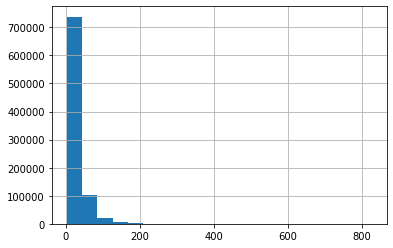

In [28]:
row_counts = pd.Series(np.array(sparse_reports.sum(1)).flatten())
row_counts.hist(bins=20);

It's also often informative to look at the distribution column sums for your sparse matrix.  This is often referred to in mathematical circles as your column marginals.  Because these are often exponentially distributed we'll look at them on a logarithmic scale with a base of 10.

1.0         12843
2.0          5666
3.0          3446
4.0          2466
5.0          1822
            ...  
168098.0        1
195608.0        1
317727.0        1
431890.0        1
506233.0        1
Length: 2408, dtype: int64

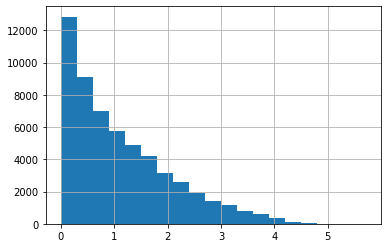

In [29]:
pd.Series(np.log10(np.array(sparse_reports.sum(0)).flatten())).hist(bins=19);#.value_counts().sort_index()
pd.Series((np.array(sparse_reports.sum(0)).flatten())).value_counts().sort_index()

We quickly see that over a fifth of our columns only showed up a single time (remember log10(1) = 0).  This is likely due to the fine level of resolution being used to describe the active ingredients.  A courser description of these active ingredients wouuld combine more ingredients and reduce the number of columns with only a single entry.  Alternatively, you could spend some time clustering the ingredients themselves together or embed them into their own vector space based on some other data.

You also have columns which showed up in about 60% of our reports.  That shouldn't be surprising considering that two of our columns are associated with gender.  

# Embedd our data into a metric space and visualize

Now that we have a simple numeric sparse matrix representation of our data we can apply a variety of dimension reduction techniques for reducing these approimately fifty five thousand dimensional vectors down to something more manageable.  

For the purposes of this notebook we are going to simply combine our InformationWeightTransformer with our UMAP algorithms.  InformationWeightTransformer will re-weight our columns to account for their marginal distributions across our data.  It can thought of as performing a similar function to the populr Term Frequency Inverse Document Frequency (TFIDF).  UMAP will attempt to preserve the local neighbourhood structure within our data and represent it within two dimensions for easy visualization and exploration.

In [30]:
info_weight_matrix = InformationWeightTransformer().fit_transform(sparse_reports)
report_matrix = TruncatedSVD(n_components=64).fit_transform(info_weight_matrix)

Now let's map these down into a two dimensional Euclidean space for visualization.  One should note that since we are embedding over 800,000 records this last step can be quite memory and time intensive.  For the sake of efficiency we will sample our matrix down to a smaller number of records and only visualize those.

In [31]:
%%time
selected = sample(range(report_matrix.shape[0]), 40000)
reducer = umap.UMAP(metric='cosine')
embedding = reducer.fit_transform(report_matrix[selected])

CPU times: user 3min, sys: 3.01 s, total: 3min 3s
Wall time: 38.3 s


Here is a scatter plot of our sampled reports.  We've shaded each point by the log of the number of categorical values used to describe our report.  There is quite a lot of interesting structure contained within even this small sample of our data.  A more detailed follow up analysis with a larger sample and an interactive plot would be a good next step for an interested data scientist.

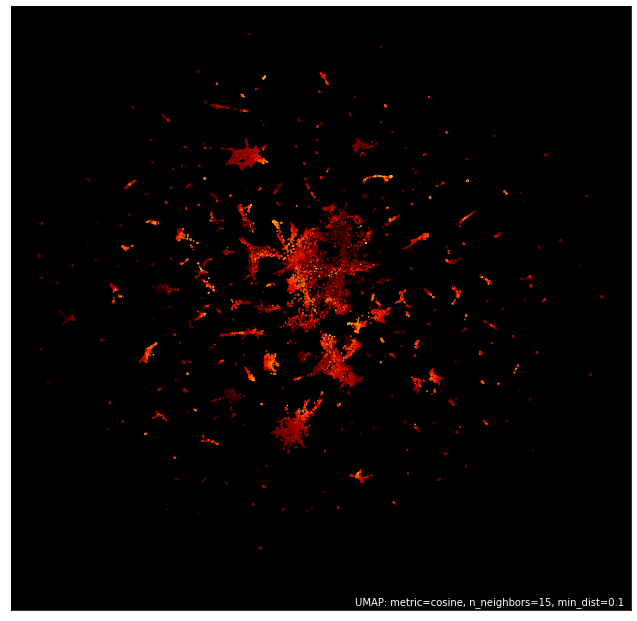

In [32]:
umap.plot.points(reducer, theme='fire', values=np.log10(row_counts[selected]));